In [ ]:
#References to the code: https://www.youtube.com/watch?v=1O_BenficgE

In [32]:
import yfinance as yf

In [33]:
sp500 = yf.Ticker('VOO')

In [34]:
sp500 = sp500.history(period='max')

In [35]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2010-09-09 00:00:00-04:00,80.609913,80.609913,79.540356,79.681915,26500,0.0,0.0,0.0
2010-09-10 00:00:00-04:00,79.965051,80.106610,79.666206,80.043694,8600,0.0,0.0,0.0
2010-09-13 00:00:00-04:00,80.971704,81.113263,80.609943,81.050346,33750,0.0,0.0,0.0
2010-09-14 00:00:00-04:00,80.877339,81.380665,80.515577,81.034630,59400,0.0,0.0,0.0
2010-09-15 00:00:00-04:00,80.704334,81.302023,80.531317,81.239113,9250,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-03-31 00:00:00-04:00,371.779999,376.339996,371.649994,376.070007,4157100,0.0,0.0,0.0
2023-04-03 00:00:00-04:00,375.600006,377.910004,375.220001,377.559998,3525300,0.0,0.0,0.0
2023-04-04 00:00:00-04:00,378.190002,378.399994,374.130005,375.429993,2713300,0.0,0.0,0.0


In [36]:
sp500.index

DatetimeIndex(['2010-09-09 00:00:00-04:00', '2010-09-10 00:00:00-04:00',
               '2010-09-13 00:00:00-04:00', '2010-09-14 00:00:00-04:00',
               '2010-09-15 00:00:00-04:00', '2010-09-16 00:00:00-04:00',
               '2010-09-17 00:00:00-04:00', '2010-09-20 00:00:00-04:00',
               '2010-09-21 00:00:00-04:00', '2010-09-22 00:00:00-04:00',
               ...
               '2023-03-24 00:00:00-04:00', '2023-03-27 00:00:00-04:00',
               '2023-03-28 00:00:00-04:00', '2023-03-29 00:00:00-04:00',
               '2023-03-30 00:00:00-04:00', '2023-03-31 00:00:00-04:00',
               '2023-04-03 00:00:00-04:00', '2023-04-04 00:00:00-04:00',
               '2023-04-05 00:00:00-04:00', '2023-04-06 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=3166, freq=None)

<Axes: xlabel='Date'>

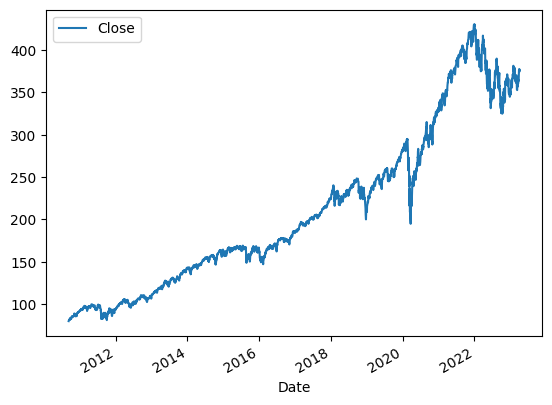

In [37]:
sp500.plot.line(y='Close', use_index=True)

In [38]:
del sp500['Dividends']
del sp500['Stock Splits']

In [39]:
#Shif one day back so you have a column showing tomorrows price
sp500['Tomorrow'] = sp500['Close'].shift(-1)

In [40]:
sp500['Target'] = (sp500['Tomorrow'] > sp500['Close']).astype(int)

In [41]:
#Remove too old data (if the market has shifted)
sp500 = sp500.loc['1990-01-01':].copy()

In [42]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1) 

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ['Close', 'Volume', 'Open', 'High', 'Low']
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [43]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [44]:
import pandas as pd

In [45]:
preds = pd.Series(preds, index=test.index)

In [46]:
precision_score(test['Target'], preds)

0.5081967213114754

In [47]:
combined = pd.concat([test['Target'], preds], axis=1)

<Axes: xlabel='Date'>

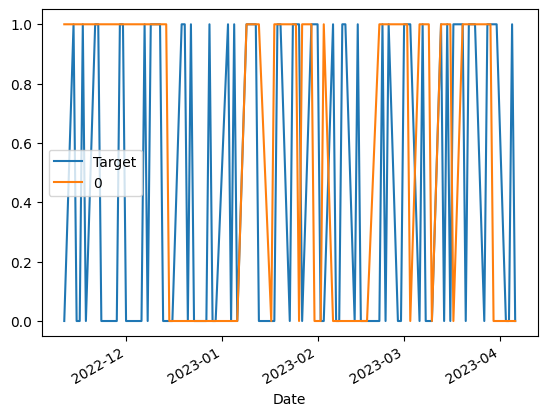

In [48]:
combined.plot()

In [49]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index, name='Predictions')
  combined = pd.concat([test['Target'], preds], axis=1)
  return combined

In [50]:
def backtest(data, model, predictors, start=2500, step=250):
  all_predictions = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)
  return pd.concat(all_predictions)

In [51]:
predictions = backtest(sp500, model, predictors)

In [52]:
predictions['Predictions'].value_counts()

1    363
0    303
Name: Predictions, dtype: int64

In [53]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5013774104683195

In [54]:
predictions['Target'].value_counts() / predictions.shape[0]

1    0.522523
0    0.477477
Name: Target, dtype: float64

In [55]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
  rolling_averages = sp500.rolling(horizon).mean()

  ratio_column = f'Close_Ratio_{horizon}'
  sp500[ratio_column] = sp500['Close'] / rolling_averages['Close']

  trend_column = f'Trend_{horizon}'
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()['Target']

  new_predictors += [ratio_column, trend_column]

In [56]:
sp500 = sp500.dropna()

In [60]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [58]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >= .6] = 1
  preds[preds < .6] = 0
  preds = pd.Series(preds, index=test.index, name='Predictions')
  combined = pd.concat([test['Target'], preds], axis=1)
  return combined

In [61]:
predictions = backtest(sp500, model, new_predictors) 

ValueError: ignored

In [62]:
predictions['Predictions'].value_counts()

1    363
0    303
Name: Predictions, dtype: int64

In [63]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5013774104683195

In [ ]:
#References to the code: https://www.youtube.com/watch?v=1O_BenficgE